<a href="https://colab.research.google.com/github/YuToyoshima/python_samples/blob/main/weathervane_serial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 風見鶏機構のモデル

Izquierdo and Lockery 2010 J. Neurosci. のモデルをpythonで実装してみました。
原点を頂点とした仮想的な濃度勾配空間に仮想線虫を置いて、シミュレーションしてみます。
パラメータをうまく最適化してあげると、線虫の塩走性行動における風見鶏機構のように、原点に向かって曲がりながら進むようになります。

このバージョンは1個体ごとに別々に計算するserialバージョンで、モデルの動作原理の理解に適しています。pythonで十分な最適化を行うためには、複数個体について並列に計算することで高速化することが重要です。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# ==== シミュレーション関数 ====
def simulate(init, param, numloop):
    dt = 0.1
    tau = 0.1
    v = 0.022

    m = int(round(param[0] / dt))
    n = int(round(param[1] / dt))
    w_on, w_off, w_osc, w_self, w_nmj, theta = param[2:]

    x = np.zeros(numloop+1)
    y = np.zeros(numloop+1)
    mu = np.zeros(numloop+1)
    activity = np.zeros(numloop+1)
    MND = np.zeros(numloop+1)
    MNV = np.zeros(numloop+1)

    x[0], y[0], mu[0] = init

    conc_timelapse_all = np.zeros(numloop + m + n + 1)
    conc_timelapse_all[:m+n] = nacl(x[0], y[0])

    conc_timelapse_log = np.zeros((numloop, m+n))

    for p in range(numloop):
        conc_timelapse_all[m+n+p] = nacl(x[p], y[p])
        conc_timelapse = conc_timelapse_all[p : m+n+p]
        conc_timelapse_log[p,:] = conc_timelapse
        activity[p+1] = sensory(conc_timelapse, m, n)

        I_onoff = w_on*activity[p+1] if activity[p+1] > 0 else w_off*-activity[p+1]
        I_osc = w_osc * np.sin(2*np.pi*p*dt/4.2)

        MND[p+1] = MND[p] + (-MND[p] + w_self*sigmoid(MND[p], theta) + I_onoff + I_osc)*(dt/tau)
        MNV[p+1] = MNV[p] + (-MNV[p] + w_self*sigmoid(MNV[p], theta) + I_onoff - I_osc)*(dt/tau)

        mu[p+1] = mu[p] + dt * w_nmj * (sigmoid(MND[p+1], theta) - sigmoid(MNV[p+1], theta))
        x[p+1] = x[p] + dt*v*np.cos(mu[p+1])
        y[p+1] = y[p] + dt*v*np.sin(mu[p+1])

    return x, y

# ==== 補助関数 ====
def nacl(x, y):
    return x**2 + y**2

def sensory(conc_timelapse, m, n):
    return np.mean(conc_timelapse[m:m+n]) - np.mean(conc_timelapse[:m])

def sigmoid(x, theta):
    return 1 / (1 + np.exp(-(x + theta)))


def objfun(param, numtrials=20, startdist=4.5, numloop=5000):
    # print("param.ndim:", param.ndim)
    # print("shape:", param.shape)

    if param.ndim==1:
      param = np.expand_dims(param, axis=0)
      # print("shape after expand:", param.shape)

    numIndividuals = param.shape[0] # handle multiple parameter set at once
    score = np.zeros(numIndividuals)

    for q in range(numIndividuals):
      tmpscore = np.zeros(numtrials)
      for p in range(numtrials):
          angle = np.random.rand() * 2*np.pi
          x0 = startdist * np.cos(angle)
          y0 = startdist * np.sin(angle)
          mu0 = np.random.rand() * 2*np.pi
          init = [x0, y0, mu0]
          x, y = simulate(init, param[q,:], numloop)
          tmpscore[p] = np.mean(np.sqrt(x**2 + y**2))/startdist
      score[q] = np.mean(tmpscore)
    return score

def visualizeResult(param):
    numtrials = 20
    startdist = 4.5
    numloop = 5000

    trajectories_x = []
    trajectories_y = []

    for p in range(numtrials):
        angle = np.random.rand() * 2*np.pi
        x0 = startdist * np.cos(angle)
        y0 = startdist * np.sin(angle)
        mu0 = np.random.rand() * 2*np.pi
        init = [x0, y0, mu0]
        x, y = simulate(init, param, numloop)
        trajectories_x.append(x)
        trajectories_y.append(y)

    plt.figure(figsize=(6,6))
    ct = np.linspace(-1 * np.pi, np.pi, 100)
    cx = startdist*np.cos(ct)
    cy = startdist*np.sin(ct)
    plt.plot(cx,cy,'k:')
    for x, y in zip(trajectories_x, trajectories_y):
        plt.plot(x, y)
    plt.axis('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Trajectories")
    plt.grid(True)
    plt.show()

**適当なパラメータでテスト実行してみる**

コードは動作するが、原点に向かわない(風見鶏っぽくない)

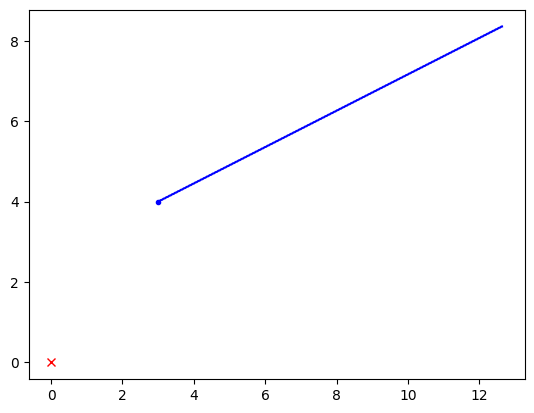

In [3]:
init0 = np.array([3,4,0]) # x=3, y=4
param0 = np.array([0.3,0.5,0.01,0.02,5,0,0.5,0])
numloop=5000
x,y = simulate(init0,param0,numloop=numloop)
plt.plot(x,y,'b-')
plt.plot(x[0],y[0],'b.')
plt.plot(0,0,'rx')

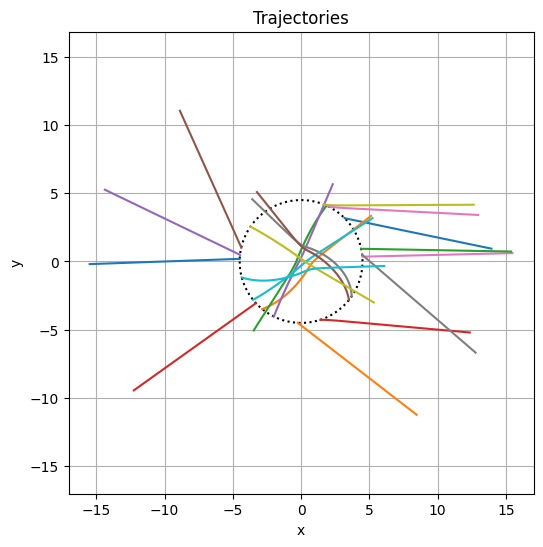

In [26]:
visualizeResult(param0)

In [38]:
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
def my_callback(xk):
    print("current best score:", objfun(xk))

def my_callback2(x, f, context):
    """
    x: 現在の探索点 (np.ndarray)
    f: その点での目的関数値
    context: 状況を示す文字列または整数
             1 = 内部ループ中
             2 = 外部ループ更新
             3 = 最終更新
    """
    f_val = np.asarray(f).item() if np.ndim(f) == 0 else np.mean(f)
    x_str = np.array2string(x, precision=3, separator=", ")
    print(f"[Callback] f = {f_val:.5f} at x = {x_str}, context = {context}")
    return False

# ===== パラメータ境界 =====
lowerbound = [0.1, 0.1, -15, -15,  0,  0, 1, -15]
upperbound = [4.2, 4.2,  15,  15, 15, 15, 3,  15]

# ===== 初期パラメータ =====
param0 = np.random.rand(len(upperbound)) * (np.array(upperbound) - np.array(lowerbound)) + np.array(lowerbound)

# ===== 最適化 =====
# result = minimize(objfun, param0, method='Nelder-Mead', callback=my_callback, options={'maxiter':10, 'disp':True}) # 範囲制約を扱えない
result = dual_annealing(objfun, bounds=list(zip(lowerbound, upperbound)), callback=my_callback2, maxfun=10) # 範囲制約付き、遅い
param_opt = result.x
fval = result.fun

print("Optimal parameters:", param_opt)
print("Objective value:", fval)



[Callback] f = 0.52138 at x = [  1.253,   1.472,  12.91 ,  -2.232,  13.106,  10.769,   1.384, -11.864], context = 0
Optimal parameters: [  1.2527195    1.47235201  12.90959328  -2.23236889  13.10611068
  10.76947856   1.38446468 -11.86407149]
Objective value: [0.5213823]


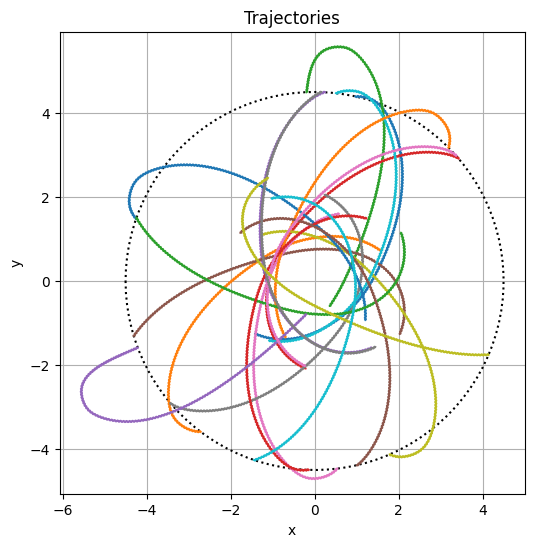

In [39]:
# ===== 結果の可視化 =====
visualizeResult(param_opt)

**scipy.dual_annealingとは別の最適化アルゴリズムとして、pymooライブラリのNSGA2 (遺伝的アルゴリズム)を使ってみます**

In [17]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.8/303.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0


In [18]:
# ---------------------------
# pymoo用ラッパーとGA設定
# ---------------------------
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.callback import Callback
import time


# 目的関数ラッパー
def objfun_for_pymoo(x):
    """
    x: 2D array shape (numIndividuals, 8)
    returns: 1D array shape (numIndividuals,)
    """
    scores = objfun(x, numtrials=20, startdist=4.5, numloop=5000)
    # pymooは最小化問題なので、スコアが高い方が良い場合は反転
    return scores

# pymoo Problem 定義
class MyProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=8,            # パラメータ数
            n_obj=1,            # 1目的
            n_constr=0,         # 制約なし
            xl = np.array([0.1, 0.1, -15, -15,  0,  0, 1, -15]),
            xu = np.array([4.2, 4.2,  15,  15, 15, 15, 3,  15])
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # X: (pop_size, n_var)
        # out["F"]: (pop_size, n_obj)
        scores = objfun_for_pymoo(X)
        # GAは最小化問題のため、スコアをそのまま返す
        out["F"] = scores.reshape(-1, 1)


class MyCallback(Callback):
    def __init__(self):
        super().__init__()
        self.best_per_gen = []
        self.mean_per_gen = []
        self.worst_per_gen = []
        self.elapsed_time = []
        self.start_time = None

    def notify(self, algorithm):
        if self.start_time is None:
            self.start_time = time.time()  # 最初の世代で開始時刻を記録

        F = algorithm.pop.get("F").flatten()  # 目的関数値 (pop_size,)
        best = np.min(F)
        mean = np.mean(F)
        worst = np.max(F)
        elapsed = time.time() - self.start_time

        # データを蓄積
        self.best_per_gen.append(best)
        self.mean_per_gen.append(mean)
        self.worst_per_gen.append(worst)
        self.elapsed_time.append(elapsed)

        # ログ表示
        print(f"Gen {algorithm.n_gen:3d} | Best: {best:.6f} | Mean: {mean:.6f} | Worst: {worst:.6f} | Elapsed: {elapsed:.1f} s")

In [19]:
# ---------------------------
# GA 実行
# ---------------------------
problem = MyProblem()

algorithm = NSGA2(
    pop_size=20,
    sampling=FloatRandomSampling(),
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 10),  # 世代数
    verbose=False,
    callback=MyCallback()
)

# ---------------------------
# 結果表示
# ---------------------------
print("Best parameters found:")
print(res.X)
print("Best score:")
print(res.F)

# T4 GPU: 45 sec (parallel version)
# CPU: 36 sec (parallel version)
# CPU: 589 sec (serial version)

Gen   1 | Best: 1.005460 | Mean: 1.519239 | Worst: 2.079400 | Elapsed: 0.0 s
Gen   2 | Best: 0.546317 | Mean: 1.199296 | Worst: 1.477384 | Elapsed: 63.1 s
Gen   3 | Best: 0.457671 | Mean: 1.009364 | Worst: 1.171984 | Elapsed: 125.3 s
Gen   4 | Best: 0.457671 | Mean: 0.875866 | Worst: 1.059692 | Elapsed: 189.2 s
Gen   5 | Best: 0.457671 | Mean: 0.704704 | Worst: 0.973736 | Elapsed: 251.6 s
Gen   6 | Best: 0.457671 | Mean: 0.603562 | Worst: 0.767539 | Elapsed: 316.0 s
Gen   7 | Best: 0.457671 | Mean: 0.542722 | Worst: 0.584848 | Elapsed: 378.3 s
Gen   8 | Best: 0.457671 | Mean: 0.525552 | Worst: 0.549990 | Elapsed: 439.6 s
Gen   9 | Best: 0.457671 | Mean: 0.513787 | Worst: 0.541811 | Elapsed: 501.5 s
Gen  10 | Best: 0.445785 | Mean: 0.498461 | Worst: 0.525641 | Elapsed: 563.3 s
Best parameters found:
[ 2.63832406  2.74378841 13.84015579 -9.89137314 14.25482626  9.39138451
  1.69231005  1.9755315 ]
Best score:
[0.44578511]


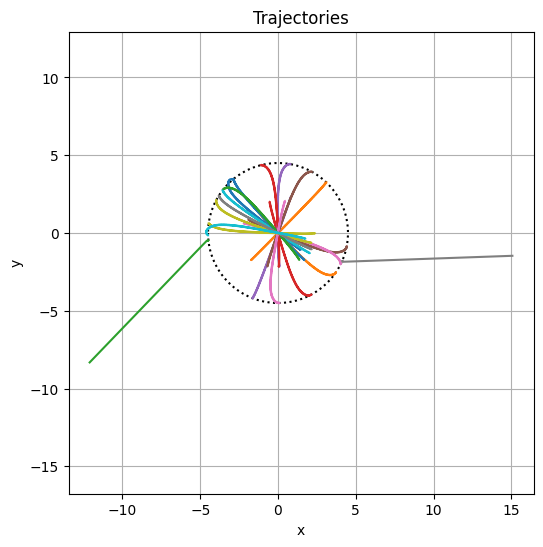

In [35]:
# ===== 結果の可視化 =====
visualizeResult(res.X)